<a href="https://colab.research.google.com/github/bluebottle66/Practical-Machine-Learning-Northwestern-/blob/master/Predict422_Week6_Kun_Yang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Retrieve data and preparation**

In [1]:
import os
from six.moves.urllib.request import urlretrieve

SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
WORK_DIRECTORY = "/tmp/mnist-data"

def maybe_download(filename):
    """A helper to download the data files if not present."""
    if not os.path.exists(WORK_DIRECTORY):
        os.mkdir(WORK_DIRECTORY)
    filepath = os.path.join(WORK_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urlretrieve(SOURCE_URL + filename, filepath)
        statinfo = os.stat(filepath)
        print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    else:
        print('Already downloaded', filename)
    return filepath

train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.


In [3]:
import gzip, binascii, struct, numpy
import matplotlib.pyplot as plt

IMAGE_SIZE = 28
PIXEL_DEPTH = 255

def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
  
    For MNIST data, the number of channels is always 1.

    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        # Skip the magic number and dimensions; we know these values.
        bytestream.read(16)

        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images)
        data = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, 1)
        return data

train_data = extract_data(train_data_filename, 60000)
test_data = extract_data(test_data_filename, 10000)

Extracting /tmp/mnist-data/train-images-idx3-ubyte.gz
Extracting /tmp/mnist-data/t10k-images-idx3-ubyte.gz


Now we retrieved all the data to train and test dataset, where data is desired formate:


> data are stored with 28 * 28 dimension, rescaled to [-0.5,0.5]


> train data have 60000 images and test data have 10000 images





Training data shape (60000, 28, 28, 1)


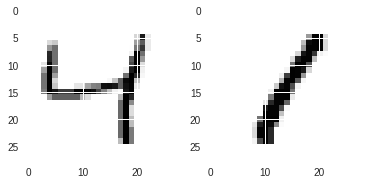

In [5]:
#take a look at our data to make sure it is what we need

get_ipython().magic(u'matplotlib inline')

print('Training data shape', train_data.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(train_data[2].reshape(28, 28), cmap=plt.cm.Greys);
ax2.imshow(train_data[3].reshape(28, 28), cmap=plt.cm.Greys);

In [6]:
#ok, now get the label
NUM_LABELS = 10

def extract_labels(filename, num_images):
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        # Skip the magic number and count; we know these values.
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = numpy.frombuffer(buf, dtype=numpy.uint8)
    # Convert to dense 1-hot representation.
    return (numpy.arange(NUM_LABELS) == labels[:, None]).astype(numpy.float32)

train_labels = extract_labels(train_labels_filename, 60000)
test_labels = extract_labels(test_labels_filename, 10000)

Extracting /tmp/mnist-data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist-data/t10k-labels-idx1-ubyte.gz


In [7]:
print('Training labels shape', train_labels.shape)
print('First label vector', train_labels[2])
print('Second label vector', train_labels[3])

Training labels shape (60000, 10)
First label vector [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Second label vector [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


the label shows digit 4 and 1 have value, it matched above data image with correct label, so this means we get our label and value all good

**Step 2: segment dato into training, test and validation set**

In [8]:
VALIDATION_SIZE = 5000

validation_data = train_data[:VALIDATION_SIZE, :, :, :]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:, :, :, :]
train_labels = train_labels[VALIDATION_SIZE:]

train_size = train_labels.shape[0]

print('Validation shape', validation_data.shape)
print('Train size', train_size)

Validation shape (5000, 28, 28, 1)
Train size 55000


**Step3: defining our model**


1.   define variables to hold weights
2.   define model graph structure
3.   stamping copies of model graph for training, testing and validation








In [0]:
import tensorflow as tf
BATCH_SIZE = 60
NUM_CHANNELS = 1
SEED = 42

In [0]:
#placeholder for data

train_data_node = tf.placeholder(
  tf.float32,
  shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))

In [0]:
#placeholder for label
train_labels_node = tf.placeholder(tf.float32,
                                   shape=(BATCH_SIZE, NUM_LABELS))

In [0]:
# For the validation and test data, we'll just hold the entire dataset in
# one constant node.
validation_data_node = tf.constant(validation_data)
test_data_node = tf.constant(test_data)

- first step: define variables

In [0]:
# now define variables

conv1_weights = tf.Variable(
  tf.truncated_normal([5, 5, NUM_CHANNELS, 32],  # 5x5 filter, depth 32.
                      stddev=0.1,
                      seed=SEED))
conv1_biases = tf.Variable(tf.zeros([32]))

In [0]:
conv2_weights = tf.Variable(
  tf.truncated_normal([5, 5, 32, 64],
                      stddev=0.1,
                      seed=SEED))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64]))

In [0]:
fc1_weights = tf.Variable(  # fully connected, depth 512.
  tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 64, 512],
                      stddev=0.1,
                      seed=SEED))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512]))

In [0]:
fc2_weights = tf.Variable(
  tf.truncated_normal([512, NUM_LABELS],
                      stddev=0.1,
                      seed=SEED))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]))

In [0]:
#look at the variable we just created
from tensorflow.python.framework import ops
All_variables_list = ops.get_collection(ops.GraphKeys.GLOBAL_VARIABLES)

In [20]:
print(All_variables_list)

[<tf.Variable 'Variable:0' shape=(5, 5, 1, 32) dtype=float32_ref>, <tf.Variable 'Variable_1:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'Variable_2:0' shape=(5, 5, 32, 64) dtype=float32_ref>, <tf.Variable 'Variable_3:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Variable_4:0' shape=(3136, 512) dtype=float32_ref>, <tf.Variable 'Variable_5:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'Variable_6:0' shape=(512, 10) dtype=float32_ref>, <tf.Variable 'Variable_7:0' shape=(10,) dtype=float32_ref>]


- second step: define graph structure

In [0]:
def model(data, train=False):
    """The Model definition."""
    # 2D convolution, with 'SAME' padding (i.e. the output feature map has
    # the same size as the input). Note that {strides} is a 4D array whose
    # shape matches the data layout: [image index, y, x, depth].
    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')

    # Bias and rectified linear non-linearity.
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))

    # Max pooling. The kernel size spec ksize also follows the layout of
    # the data. Here we have a pooling window of 2, and a stride of 2.
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')

    # Reshape the feature map cuboid into a 2D matrix to feed it to the
    # fully connected layers.
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(
        pool,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
  
    # Fully connected layer. Note that the '+' operation automatically
    # broadcasts the biases.
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)

    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    if train:
        hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
    return tf.matmul(hidden, fc2_weights) + fc2_biases

- step3: stamp out multiple copies for traing, testing and validation

In [22]:
# Training computation: logits + cross-entropy loss.
logits = model(train_data_node, True)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
  labels=train_labels_node, logits=logits))

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
# Add the regularization term to the loss.
loss += 5e-4 * regularizers

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
  0.01,                # Base learning rate.
  batch * BATCH_SIZE,  # Current index into the dataset.
  train_size,          # Decay step.
  0.95,                # Decay rate.
  staircase=True)
# Use simple momentum for the optimization.
optimizer = tf.train.MomentumOptimizer(learning_rate,
                                       0.9).minimize(loss,
                                                     global_step=batch)

# Predictions for the minibatch, validation set and test set.
train_prediction = tf.nn.softmax(logits)
# We'll compute them only once in a while by calling their {eval()} method.
validation_prediction = tf.nn.softmax(model(validation_data_node))
test_prediction = tf.nn.softmax(model(test_data_node))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



**Training and Visualization of the results**

In [0]:
# Create a new interactive session that we'll use in
# subsequent code cells.
s = tf.InteractiveSession()

# Use our newly created session as the default for 
# subsequent operations.
s.as_default()

# Initialize all the variables we defined above.
tf.global_variables_initializer().run()

In [26]:
BATCH_SIZE = 60

# Grab the first BATCH_SIZE examples and labels.
batch_data = train_data[:BATCH_SIZE, :, :, :]
batch_labels = train_labels[:BATCH_SIZE]

print(batch_data.shape)
print(batch_labels.shape)

(60, 28, 28, 1)
(60, 10)


In [0]:
feed_dict = {train_data_node: batch_data,
             train_labels_node: batch_labels}

# Run the graph and fetch some of the nodes.
_, l, lr, predictions = s.run(
  [optimizer, loss, learning_rate, train_prediction],
  feed_dict=feed_dict)

In [29]:
print(predictions[0])
print('First prediction', numpy.argmax(predictions[0]))
print(predictions.shape)
print('All predictions', numpy.argmax(predictions, 1))

[2.2539226e-04 4.7622027e-05 1.6686729e-03 5.6782723e-05 6.0343301e-01
 4.3496866e-02 2.1931728e-05 1.4128604e-04 1.5490332e-05 3.5089296e-01]
First prediction 4
(60, 10)
All predictions [4 4 2 7 7 7 7 7 7 7 7 7 0 8 9 0 7 7 0 7 4 0 5 0 9 9 7 0 7 4 7 7 7 0 7 7 9
 7 9 9 0 7 7 7 2 7 0 7 2 9 9 9 9 9 0 7 9 4 8 7]


In [30]:
print('Batch labels', numpy.argmax(batch_labels, 1))
correct = numpy.sum(numpy.argmax(predictions, 1) == numpy.argmax(batch_labels, 1))
total = predictions.shape[0]

print(float(correct) / float(total))

Batch labels [7 3 4 6 1 8 1 0 9 8 0 3 1 2 7 0 2 9 6 0 1 6 7 1 9 7 6 5 5 8 8 3 4 4 8 7 3
 6 4 6 6 3 8 8 9 9 4 4 0 7 8 1 0 0 1 8 5 7 1 7]
0.06666666666666667


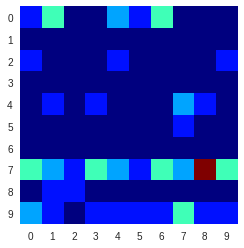

In [31]:
confusions = numpy.zeros([10, 10], numpy.float32)
bundled = zip(numpy.argmax(predictions, 1), numpy.argmax(batch_labels, 1))
for predicted, actual in bundled:
  confusions[predicted, actual] += 1

plt.grid(False)
plt.xticks(numpy.arange(NUM_LABELS))
plt.yticks(numpy.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

Above shows using the first 60 data to traint the model, the result is very bad. we can compare between our predict vs label to see how far the predication is from the correct value. the correation ratio is only 6%

In [0]:
#wrap above into a function
def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = numpy.sum(numpy.argmax(predictions, 1) == numpy.argmax(labels, 1))
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = numpy.zeros([10, 10], numpy.float32)
    bundled = zip(numpy.argmax(predictions, 1), numpy.argmax(labels, 1))
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

In [35]:
steps = train_size // BATCH_SIZE
print(train_size)
print(BATCH_SIZE)
print(steps)

55000
60
916


In [36]:

for step in range(steps):
    # Compute the offset of the current minibatch in the data.
    # Note that we could use better randomization across epochs.
    offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
    batch_data = train_data[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    # This dictionary maps the batch data (as a numpy array) to the
    # node in the graph it should be fed to.
    feed_dict = {train_data_node: batch_data,
                 train_labels_node: batch_labels}
    # Run the graph and fetch some of the nodes.
    _, l, lr, predictions = s.run(
      [optimizer, loss, learning_rate, train_prediction],
      feed_dict=feed_dict)
    
    # Print out the loss periodically.
    if step % 100 == 0:
        error, _ = error_rate(predictions, batch_labels)
        print('Step %d of %d' % (step, steps))
        print('Mini-batch loss: %.5f Error: %.5f Learning rate: %.5f' % (l, error, lr))
        print('Validation error: %.1f%%' % error_rate(
              validation_prediction.eval(), validation_labels)[0])


Step 0 of 916
Mini-batch loss: 7.71259 Error: 91.66667 Learning rate: 0.01000
Validation error: 88.9%
Step 100 of 916
Mini-batch loss: 3.28615 Error: 5.00000 Learning rate: 0.01000
Validation error: 5.5%
Step 200 of 916
Mini-batch loss: 3.29361 Error: 8.33333 Learning rate: 0.01000
Validation error: 3.7%
Step 300 of 916
Mini-batch loss: 3.19405 Error: 3.33333 Learning rate: 0.01000
Validation error: 3.4%
Step 400 of 916
Mini-batch loss: 3.07051 Error: 1.66667 Learning rate: 0.01000
Validation error: 2.6%
Step 500 of 916
Mini-batch loss: 3.02596 Error: 1.66667 Learning rate: 0.01000
Validation error: 2.4%
Step 600 of 916
Mini-batch loss: 3.05108 Error: 3.33333 Learning rate: 0.01000
Validation error: 1.8%
Step 700 of 916
Mini-batch loss: 3.11480 Error: 6.66667 Learning rate: 0.01000
Validation error: 2.0%
Step 800 of 916
Mini-batch loss: 3.09262 Error: 6.66667 Learning rate: 0.01000
Validation error: 1.9%
Step 900 of 916
Mini-batch loss: 2.85356 Error: 0.00000 Learning rate: 0.01000
Val

We can see after we go through the 916 steps to train, the erro rate is going down a lot. for our validation set, the error is at 2%. Next we can try how our model performs on our testing set.

In [37]:
test_error, confusions = error_rate(test_prediction.eval(), test_labels)
print('Test error: %.1f%%' % test_error)

Test error: 2.0%


matching the performance with our validation set

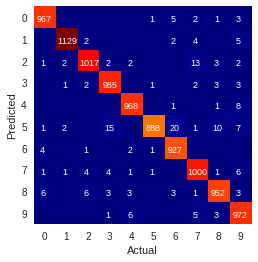

In [38]:
#take a look at our plots
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(numpy.arange(NUM_LABELS))
plt.yticks(numpy.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

Looks like the mispredictions are mostly between '2' adn '7'; '5' and '3'; '5' and '6'; '5' and '8'

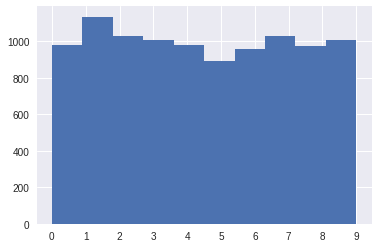

In [39]:
#take a look how the histogram looks like for the labels in our test set

plt.xticks(numpy.arange(NUM_LABELS))
plt.hist(numpy.argmax(test_labels, 1));

In [40]:
#try rerun our training to see whether our model will improve
for step in range(steps):
    # Compute the offset of the current minibatch in the data.
    # Note that we could use better randomization across epochs.
    offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
    batch_data = train_data[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    # This dictionary maps the batch data (as a numpy array) to the
    # node in the graph it should be fed to.
    feed_dict = {train_data_node: batch_data,
                 train_labels_node: batch_labels}
    # Run the graph and fetch some of the nodes.
    _, l, lr, predictions = s.run(
      [optimizer, loss, learning_rate, train_prediction],
      feed_dict=feed_dict)
    
    # Print out the loss periodically.
    if step % 100 == 0:
        error, _ = error_rate(predictions, batch_labels)
        print('Step %d of %d' % (step, steps))
        print('Mini-batch loss: %.5f Error: %.5f Learning rate: %.5f' % (l, error, lr))
        print('Validation error: %.1f%%' % error_rate(
              validation_prediction.eval(), validation_labels)[0])

Step 0 of 916
Mini-batch loss: 3.00177 Error: 6.66667 Learning rate: 0.00950
Validation error: 2.2%
Step 100 of 916
Mini-batch loss: 2.94567 Error: 3.33333 Learning rate: 0.00950
Validation error: 1.7%
Step 200 of 916
Mini-batch loss: 2.89360 Error: 3.33333 Learning rate: 0.00950
Validation error: 1.6%
Step 300 of 916
Mini-batch loss: 2.83109 Error: 3.33333 Learning rate: 0.00950
Validation error: 1.5%
Step 400 of 916
Mini-batch loss: 2.82303 Error: 3.33333 Learning rate: 0.00950
Validation error: 1.5%
Step 500 of 916
Mini-batch loss: 2.73074 Error: 0.00000 Learning rate: 0.00950
Validation error: 1.4%
Step 600 of 916
Mini-batch loss: 2.74509 Error: 1.66667 Learning rate: 0.00950
Validation error: 1.6%
Step 700 of 916
Mini-batch loss: 2.81013 Error: 6.66667 Learning rate: 0.00950
Validation error: 1.5%
Step 800 of 916
Mini-batch loss: 2.70353 Error: 3.33333 Learning rate: 0.00950
Validation error: 1.4%
Step 900 of 916
Mini-batch loss: 2.61659 Error: 0.00000 Learning rate: 0.00950
Valid

Ok, with another round of training, we can see the validation error is further reduced to 1.3%. we can see how our model performs with testing set again

Test error: 1.5%


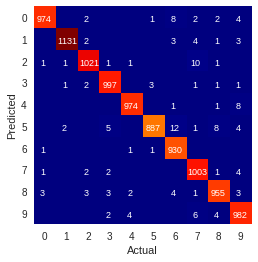

In [42]:
test_error, confusions = error_rate(test_prediction.eval(), test_labels)
print('Test error: %.1f%%' % test_error)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(numpy.arange(NUM_LABELS))
plt.yticks(numpy.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

**Our prediction result on test data are further improved too! - 1.5% error now**


**Now using Pickle to export binary object for benchmark experiment usage**

In [43]:
# check data for pickle dump
print('\ntrain_data object:', type(train_data), train_data.shape)    
print('\ntrain_labels object:', type(train_labels),  train_labels.shape)  
print('\nvalidation_data object:', type(validation_data),  validation_data.shape)  
print('\nvalidation_labels object:', type(validation_labels),  validation_labels.shape)  
print('\ntest_data object:', type(test_data),  test_data.shape)  
print('\ntest_labels object:', type(test_labels),  test_labels.shape)  


train_data object: <class 'numpy.ndarray'> (55000, 28, 28, 1)

train_labels object: <class 'numpy.ndarray'> (55000, 10)

validation_data object: <class 'numpy.ndarray'> (5000, 28, 28, 1)

validation_labels object: <class 'numpy.ndarray'> (5000, 10)

test_data object: <class 'numpy.ndarray'> (10000, 28, 28, 1)

test_labels object: <class 'numpy.ndarray'> (10000, 10)


In [44]:
import pickle  # used for dumping and loading binary files

# define collection of objects to export as binary file using pickle.
data = {
    'train_data': train_data,
    'train_labels': train_labels,
    'validation_data': validation_data,
    'validation_labels': validation_labels,
    'test_data': test_data,
    'test_labels': test_labels}

# write to binary file
with open('mnist_data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

print('\n Run complete. data objects sent to binary file  mnist_data.pickle')


 Run complete. data objects sent to binary file  mnist_data.pickle


In [45]:
with open('mnist_data.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)

# extract objects from the dictionary object data
train_data = data['train_data']
train_labels = data['train_labels'] 
validation_data = data['validation_data'] 
validation_labels = data['validation_labels'] 
test_data = data['test_data'] 
test_labels = data['test_labels']  
    
# check data from pickle load
print('\ntrain_data object:', type(train_data), train_data.shape)    
print('\ntrain_labels object:', type(train_labels),  train_labels.shape)  
print('\nvalidation_data object:', type(validation_data),  validation_data.shape)  
print('\nvalidation_labels object:', type(validation_labels),  validation_labels.shape)  
print('\ntest_data object:', type(test_data),  test_data.shape)  
print('\ntest_labels object:', type(test_labels),  test_labels.shape)  

print('\ndata input complete')


train_data object: <class 'numpy.ndarray'> (55000, 28, 28, 1)

train_labels object: <class 'numpy.ndarray'> (55000, 10)

validation_data object: <class 'numpy.ndarray'> (5000, 28, 28, 1)

validation_labels object: <class 'numpy.ndarray'> (5000, 10)

test_data object: <class 'numpy.ndarray'> (10000, 28, 28, 1)

test_labels object: <class 'numpy.ndarray'> (10000, 10)

data input complete


In [0]:
import numpy as np
import pandas as pd
import time

# user-defined function to convert binary digits to digits 0-9
# add digits to the end of our label data

def label_transform(y_in):
    for i in range(len(y_in)):
        if (y_in[i] == 1): return i

y_train = []    
for j in range(train_labels.shape[0]):
    y_train.append(label_transform(train_labels[j,]))  
y_train = np.asarray(y_train)    

y_validation = []    
for j in range(validation_labels.shape[0]):
    y_validation.append(label_transform(validation_labels[j,]))  
y_validation = np.asarray(y_validation)    

y_test = []    
for j in range(test_labels.shape[0]):
    y_test.append(label_transform(test_labels[j,]))  
y_test = np.asarray(y_test) 

In [0]:
# 28x28 matrix of entries converted to vector of 784 entries    
X_train = train_data.reshape(55000, 784)
X_validation = validation_data.reshape(5000, 784)    
X_test = test_data.reshape(10000, 784) 

In [48]:
# check data intended for Scikit Learn input
print('\nX_train object:', type(X_train), X_train.shape)    
print('\ny_train object:', type(y_train),  y_train.shape)  
print('\nX_validation object:', type(X_validation),  X_validation.shape)  
print('\ny_validation object:', type(y_validation),  y_validation.shape)  
print('\nX_test object:', type(X_test),  X_test.shape)  
print('\ny_test object:', type(y_test),  y_test.shape)   


X_train object: <class 'numpy.ndarray'> (55000, 784)

y_train object: <class 'numpy.ndarray'> (55000,)

X_validation object: <class 'numpy.ndarray'> (5000, 784)

y_validation object: <class 'numpy.ndarray'> (5000,)

X_test object: <class 'numpy.ndarray'> (10000, 784)

y_test object: <class 'numpy.ndarray'> (10000,)


In [49]:
# Scikit Learn MLP Classification does validation internally, 
# so there is with no need for a separate validation set.
# We will combine the train and validation sets.

X_train_expanded = np.vstack((X_train, X_validation))
y_train_expanded = np.vstack((y_train.reshape(55000,1), y_validation.reshape(5000,1)))

print('\nX_train_expanded object:', type(X_train_expanded),  X_train_expanded.shape)  
print('\ny_train_expanded object:', type(y_train_expanded), y_train_expanded.shape)  


X_train_expanded object: <class 'numpy.ndarray'> (60000, 784)

y_train_expanded object: <class 'numpy.ndarray'> (60000, 1)


**Below build up our Scikit Learn MLPClassifier model as benchmark**

In [0]:
RANDOM_SEED = 9999

from sklearn.neural_network import MLPClassifier


In [0]:
names = ['ANN-2-Layers-10-Nodes-per-Layer',
         'ANN-2-Layers-20-Nodes-per-Layer',
         'ANN-5-Layers-10-Nodes-per-Layer',
         'ANN-5-Layers-20-Nodes-per-Layer']

layers = [2, 2, 5, 5]
nodes_per_layer = [10, 20, 10, 20]
treatment_condition = [(10, 10), 
                       (20, 20), 
                       (10, 10, 10, 10, 10), 
                       (20, 20, 20, 20, 20)] 

In [0]:
# note that validation is included in the method  
# for validation_fraction 0.083333, note that 60000 * 0.83333 = 5000    
methods = [MLPClassifier(hidden_layer_sizes=treatment_condition[0], activation='relu', 
              solver='adam', alpha=0.0001, batch_size='auto', 
              learning_rate='constant', learning_rate_init=0.001, 
              power_t=0.5, max_iter=200, shuffle=True, 
              random_state=RANDOM_SEED, 
              tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
              nesterovs_momentum=True, early_stopping=False, 
              validation_fraction=0.083333, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    MLPClassifier(hidden_layer_sizes=treatment_condition[1], activation='relu', 
              solver='adam', alpha=0.0001, batch_size='auto', 
              learning_rate='constant', learning_rate_init=0.001, 
              power_t=0.5, max_iter=200, shuffle=True, 
              random_state=RANDOM_SEED, 
              tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
              nesterovs_momentum=True, early_stopping=False, 
              validation_fraction=0.083333, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    MLPClassifier(hidden_layer_sizes=treatment_condition[2], activation='relu', 
              solver='adam', alpha=0.0001, batch_size='auto', 
              learning_rate='constant', learning_rate_init=0.001, 
              power_t=0.5, max_iter=200, shuffle=True, 
              random_state=RANDOM_SEED, 
              tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
              nesterovs_momentum=True, early_stopping=False, 
              validation_fraction=0.083333, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    MLPClassifier(hidden_layer_sizes=treatment_condition[3], activation='relu', 
              solver='adam', alpha=0.0001, batch_size='auto', 
              learning_rate='constant', learning_rate_init=0.001, 
              power_t=0.5, max_iter=200, shuffle=True, 
              random_state=RANDOM_SEED, 
              tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
              nesterovs_momentum=True, early_stopping=False, 
              validation_fraction=0.083333, beta_1=0.9, beta_2=0.999, epsilon=1e-08)]



*   validation_fraction 0.083333; 60000*0.833=5000; so validation size fits what is used in neural network
*   solver = 'adam'
*   activation = 'relu', fitting used in neural network
*   test 4 different structure



In [53]:
index_for_method = 0 
training_performance_results = []
test_performance_results = []
processing_time = []
   
for name, method in zip(names, methods):
    print('\n------------------------------------')
    print('\nMethod:', name)
    print('\n  Specification of method:', method)
    start_time = time.clock()
    method.fit(X_train, y_train)
    end_time = time.clock()
    runtime = end_time - start_time  # seconds of wall-clock time 
    print("\nProcessing time (seconds): %f" % runtime)        
    processing_time.append(runtime)

    # mean accuracy of prediction in training set
    training_performance = method.score(X_train_expanded, y_train_expanded)
    print("\nTraining set accuracy: %f" % training_performance)
    training_performance_results.append(training_performance)

    # mean accuracy of prediction in test set
    test_performance = method.score(X_test, y_test)
    print("\nTest set accuracy: %f" % test_performance)
    test_performance_results.append(test_performance)
                
    index_for_method += 1


------------------------------------

Method: ANN-2-Layers-10-Nodes-per-Layer

  Specification of method: MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=9999,
       shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.083333, verbose=False, warm_start=False)

Processing time (seconds): 135.987975

Training set accuracy: 0.934983

Test set accuracy: 0.927300

------------------------------------

Method: ANN-2-Layers-20-Nodes-per-Layer

  Specification of method: MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200,

In [54]:
from collections import OrderedDict  

results = pd.DataFrame(OrderedDict([('Method Name', names),
                        ('Layers', layers),
                        ('Nodes per Layer', nodes_per_layer),
                        ('Processing Time', processing_time),
                        ('Training Set Accuracy', training_performance_results),
                        ('Test Set Accuracy', test_performance_results)]))

print('\nBenchmark Experiment: Scikit Learn Artificial Neural Networks\n')
print(results) 


Benchmark Experiment: Scikit Learn Artificial Neural Networks

                       Method Name  Layers  Nodes per Layer  Processing Time  \
0  ANN-2-Layers-10-Nodes-per-Layer       2               10       135.987975   
1  ANN-2-Layers-20-Nodes-per-Layer       2               20       218.264116   
2  ANN-5-Layers-10-Nodes-per-Layer       5               10       149.282256   
3  ANN-5-Layers-20-Nodes-per-Layer       5               20       118.972399   

   Training Set Accuracy  Test Set Accuracy  
0               0.934983             0.9273  
1               0.966950             0.9517  
2               0.943900             0.9330  
3               0.964783             0.9522  
